In [1]:
!python --version

Python 3.10.10+


In [5]:
from transformers import BertTokenizer
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from transformers import BertGenerationEncoder

In [508]:
def tokenize_and_encode(sentence: str, encoder: BertGenerationEncoder, tokenizer: BertTokenizer, max_sentence_len: int = 10) -> torch.Tensor:
  """Tokenizes and encodes sentence, returning a torch tensor"""
  # -- tokenize input
  tokens = tokenizer(sentence, max_length=max_sentence_len, truncation=True).input_ids
  # --  add padding to tokens
  cl = len(tokens)
  ps = max_sentence_len - cl # amount of padding for sentence to be of length max_sentence_len
  tokens_padded = F.pad(torch.tensor(tokens), [-1,ps],"constant",0).unsqueeze(0)
  # -- encode
  outputs = encoder(tokens_padded)
  outputs = outputs.last_hidden_state

  return outputs

def get_top_features(encoded_tensor:torch.Tensor, n_feat: int=3, weight_type: str='rang') -> list[torch.Tensor]:
  """Performs SVD and returns the principal components according to n_feat"""
  u, s, v = torch.svd(encoded_tensor.squeeze(0))
  B_r = u[:, :n_feat] * s[:n_feat] # principal components
  # -- weights
  S = torch.diag(s)
  r = torch.cumsum(S**2 / torch.sum(S**2), 0)
  # the impact that the vector has on the data
  weight = r.mean(0)
    
  match weight_type:
    case 'accum':
        weight = weight / weight.sum()
    case 'rang':
        weight = (weight.max() - weight) / (weight.max() - weight.min())
    case None:
        weight = weight / weight
    case _:
        print("weight type should be 'accum' or 'rang': defaulting to accum")
        weight = weight / weight.sum()
  
  return B_r, weight[:n_feat]

def plot_feat(features:torch.Tensor, sentences:list[str]):
    num_feat = len(features)
    fig, axes = plt.subplots(nrows=1, ncols=num_feat, figsize=(num_feat * 2 , num_feat-1))
    
    for i, ax in enumerate(axes):
        ax.set_title(str(i)+')', y=-0.15)
        ax.imshow(features[i].detach().numpy())
        axes[num_feat-1].text(5, 0.5 * (i+1), str(i) +') '+ sentences[i])
        
    fig.suptitle('Sentence comparison: Tokenized + BertEncoded + SVD',x=.65, fontsize=16)
    fig.show()

def calculate_errors(features:torch.Tensor, weights:torch.Tensor, error_type='mse', non_lin_fn:str ='tanh', threshold=1) -> torch.Tensor:
    from torch import nn
    
    error_measure = nn.MSELoss()
    
    match error_type:
        case 'mse':
            error_measure = nn.MSELoss()
        case 'mae':
            error_measure = nn.L1Loss()
        case 'cre':
            error_measure = nn.CrossEntropyLoss()
        case _:
            error_measure = nn.MSELoss()
            
    n = len(features)
    
    conf_matrix = torch.zeros(n,n)
    
    for i in range(n):
        for j in range(n):
            error = 0
            for c in range(len(weights[0])):
                error += error_measure(features[i][:,c], features[j][:,c]) * (weights[i] + weights[j] / 2)[c]    
            conf_matrix[i,j] = error
            
    match non_lin_fn:
        case 'sigmoid':
            sigma = nn.Sigmoid()
        case 'relu':
            sigma = nn.ReLU()
        case 'tanh':
            sigma = nn.Tanh()
        case 'gelu':
            sigma = nn.GELU()
        case 'softmax':
            sigma = nn.Softmax()
        case None:
            sigma = lambda x:  x
        case _ :
            print("Non-existing activation function: Will default to sigmoid")
            sigma = nn.Sigmoid()

    error = sigma(conf_matrix)
    error[error>threshold] = 1000
    
    return error

def plot_error(error:torch.Tensor, sentences:list[str]):    
    plt.imshow(error.detach().numpy(), cmap='jet')
    n = len(sentences)
    plt.title('Cross-comparison: Sentence',x=.5, y=1, fontsize=16)
    #plt.minorticks_on()
    #plt.grid(visible=True, which='major')
    
    for i, s in enumerate(sentences):
        plt.text(1 * n, 0.25 * i, str(i) + ') ' + s)
    

In [509]:
# -- load pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# -- load pretrained bert encoder
encoder = BertGenerationEncoder.from_pretrained("bert-base-uncased")

# -- load sentences to compare
sentences = ['how is the weather?', 'is it cold or warm?', 'a monkey throwing a banana', 'how are you?', 'are you ok?', 'how are you feeling?']

# -- tokenize and encode inputs
encoded = list(map(lambda sentence: tokenize_and_encode(sentence, encoder, tokenizer), sentences)) # returns list of tokenized and encoded sentence

# -- perform svd
features, weights = list(zip(*map(lambda feature: get_top_features(feature, n_feat=5, weight_type='accum'), encoded)))


You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertGenerationEncoder: ['cls.seq_relationship.weight', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a 

/tmp/ipykernel_50449/187122023.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


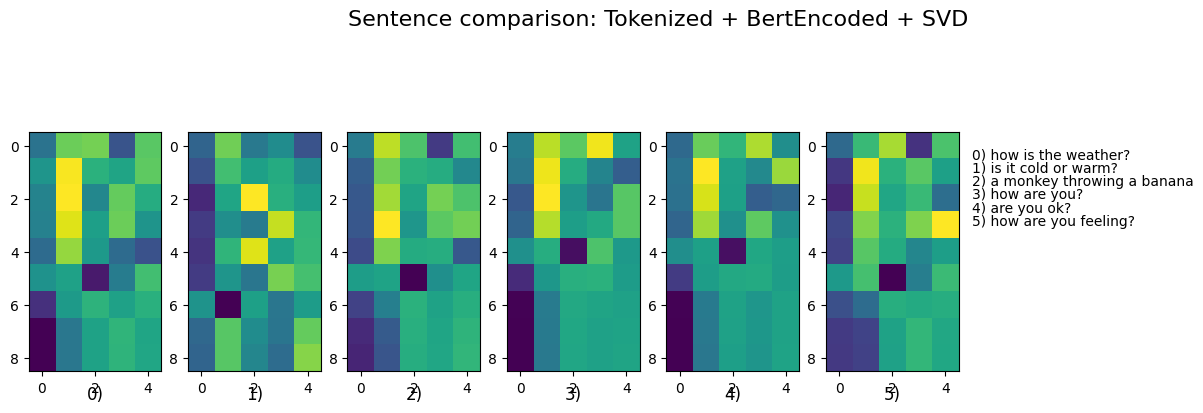

In [510]:
# -- plot features
plot_feat(features, sentences)

tensor([[ 0.0000, 81.8440, 15.5477, 34.1621, 30.1111, 28.9641],
        [80.2428,  0.0000, 47.6537, 76.4808, 79.2636, 41.9405],
        [15.5301, 48.9618,  0.0000, 39.5733, 42.0643,  8.2959],
        [33.9286, 77.3666, 39.5575,  0.0000,  4.2550, 49.6914],
        [29.7840, 80.2287, 41.7852,  4.3849,  0.0000, 50.2744],
        [29.1238, 42.9060,  8.2690, 49.5777, 50.1849,  0.0000]],
       grad_fn=<IndexPutBackward0>)


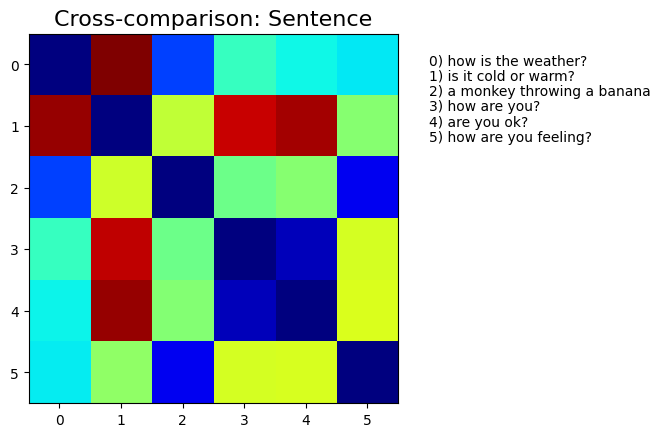

In [511]:
# -- calucalte errors (sentence cross-comparison) 
errors = calculate_errors(features, weights, error_type='mse', non_lin_fn=None, threshold=10000)
print(errors)
plot_error(errors, sentences)